In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

pd.options.display.max_columns = 1000      # set column display
pd.options.display.max_rows = 1000         # set row display
pd.options.mode.chained_assignment = None  # default='warn'

yr_20 = gpd.read_file('../data/shapefiles/joined/merged20_final.geojson')
yr_19 = gpd.read_file('../data/shapefiles/joined/merged19_final.geojson')

## Yearly Joined Data

In [76]:
print(f"2019: {yr_19.shape[0]} records, {yr_19.shape[1]} features")
print(f"2020: {yr_20.shape[0]} records, {yr_20.shape[1]} features")
print()
print(f"Missing Features 2020: {set(yr_19.columns) - set(yr_20.columns)}")

2019: 287760 records, 29 features
2020: 290158 records, 26 features

Missing Features 2020: {'uid', 'fhv_inflow_counts', 'fhv_outflow_counts'}


## Identifying Nightlife Clusters

In [77]:
venues = gpd.read_file('../data/shapefiles/nyc/venues_hexbinned.geojson')

boros = gpd.read_file('../data/shapefiles/nyc/boro_bounds.geojson')
boros = boros.to_crs(venues.crs)

subways = gpd.read_file('../data/shapefiles/subway/routes/routes_nyc_subway_may2019.shp').to_crs(venues.crs)

In [78]:
# calculate pct. share of businesses that are venues
venues['venue_pct'] = (venues['venue_count'] / venues['business_count']) * 100

# calculate z score for citywide data
venues['count_z'] = np.abs(stats.zscore(venues['venue_count']))
venues['pct_z'] = (venues['venue_pct'] - venues['venue_pct'].mean())/\
                   venues['venue_pct'].std()

# add borough information to venues data
venues = gpd.sjoin(venues,
                   boros[['boro_code', 'boro_name', 'geometry']],
                   how='left'
                  )\
            .drop(['index_right'],
                  axis=1
                 )

# eliminate duplicates along boro borders
venues.drop_duplicates(subset='hex_id_8',
                       keep='first',
                       inplace=True
                      )

venues.head(3)

,hex_id_8,venue_count,business_count,geometry,venue_pct,count_z,pct_z,boro_code,boro_name
0,882a100d65fffff,144.0,6412,"POLYGON ((301714.781 65863.222, 301880.715 663...",2.245789,12.351170,0.904274,1,Manhattan
1,882a1072cbfffff,136.0,2761,"POLYGON ((300594.554 61028.530, 301133.174 611...",4.925752,11.648765,2.431049,1,Manhattan
2,882a100d2dfffff,110.0,16567,"POLYGON ((301010.106 65250.815, 300471.361 651...",0.663971,9.365951,0.003113,1,Manhattan


(275448.37506285455, 327835.0550581825, 33862.23093684847, 86085.8516005284)

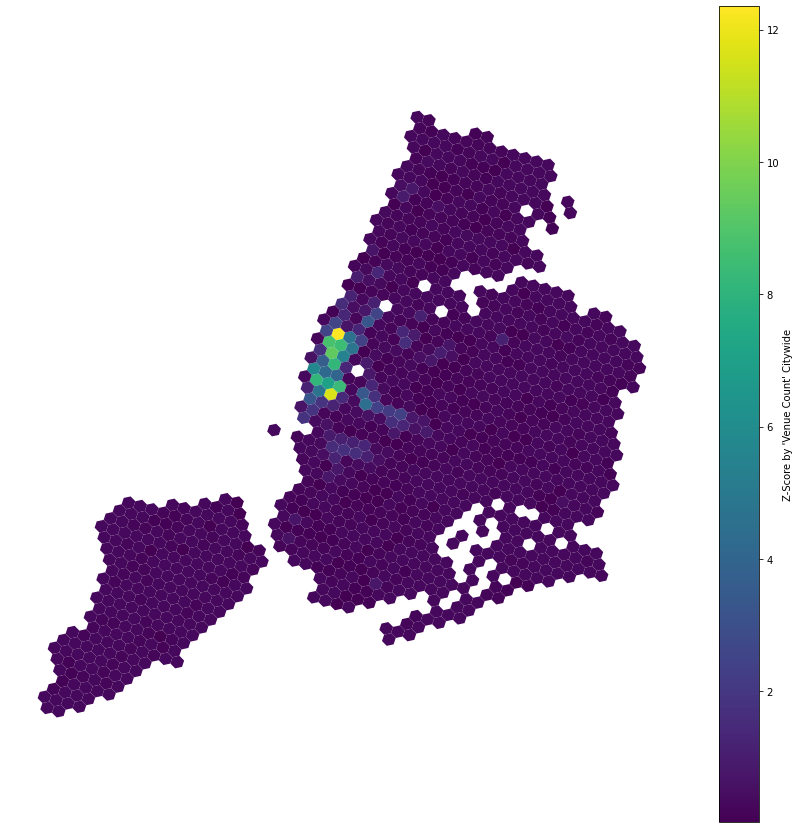

In [79]:
venues.plot(figsize     = (15,15),
            column      = 'count_z',
            legend      = True,
            legend_kwds = {'label': "Z-Score by 'Venue Count' Citywide",
                          'orientation': 'vertical'}
           );

plt.axis('off')

(275448.37506285455, 327835.0550581825, 33862.23093684847, 86085.8516005284)

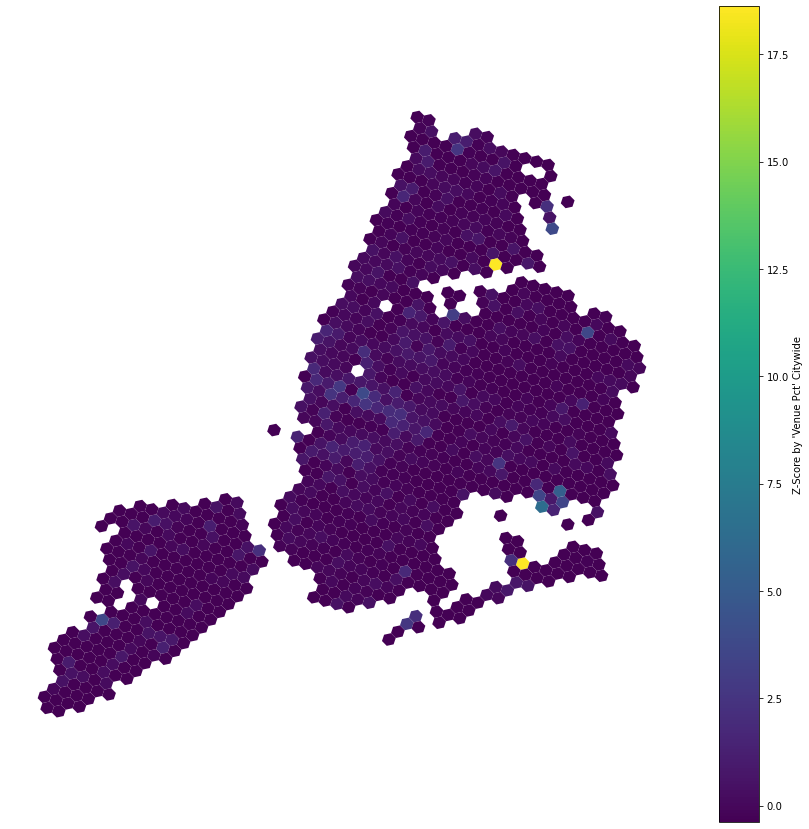

In [80]:
venues.plot(figsize     = (15,15),
            column      = 'pct_z',
            legend      = True,
            legend_kwds = {'label': "Z-Score by 'Venue Pct' Citywide",
                          'orientation': 'vertical'}
           );

plt.axis('off')

#### Fig. 1a & 1b: Maps of Citywide Nightlife Cluster Outliers (colored by Z-score of venue count and venue pct.)

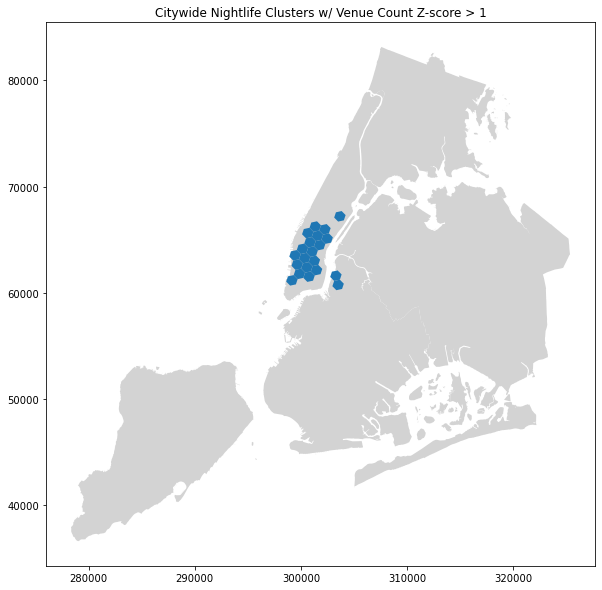

In [139]:
ax = boros.plot(color='lightgrey',
                zorder=1,
                figsize=(10,10)
               )

venues[venues['count_z'] > 3].plot(ax=ax,
                             zorder=2
                            )

plt.title('Citywide Nightlife Clusters w/ Venue Count Z-score > 1');

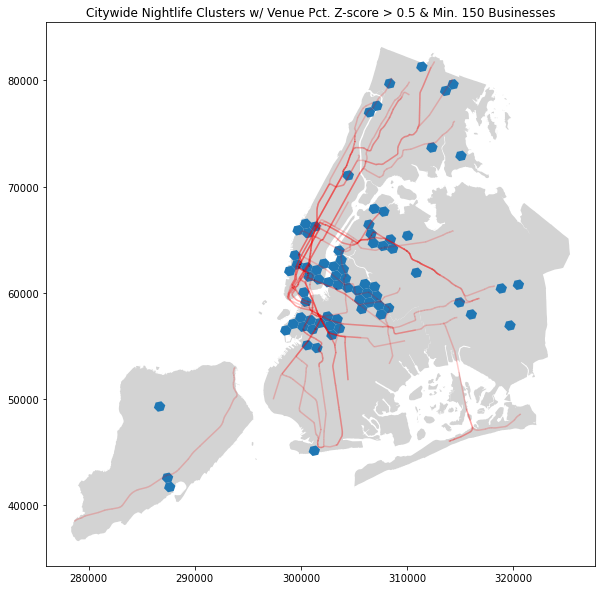

In [151]:
z_threshold = .5
biz_threshold = 150

ax = boros.plot(color='lightgrey',
                zorder=1,
                figsize=(10,10)
               )

venues[(venues['pct_z'] > .5) & (venues['business_count'] > 150)].plot(ax=ax,
                             zorder=2
                            )

subways.plot(ax=ax,
             color='red',
             alpha=0.2,
             zorder=3)


plt.title(f"Citywide Nightlife Clusters w/ Venue Pct. Z-score > " +
          f"{z_threshold} & Min. {biz_threshold} Businesses");

# manhattan? | bronx? | brooklyn? | queens? | staten_island?
# 1          | 0      | 0         | 0       | 0

#### Fig. 2a & 2b: Maps of Citywide Nightlife Cluster Outliers (filtered by Z-score > 1.5)

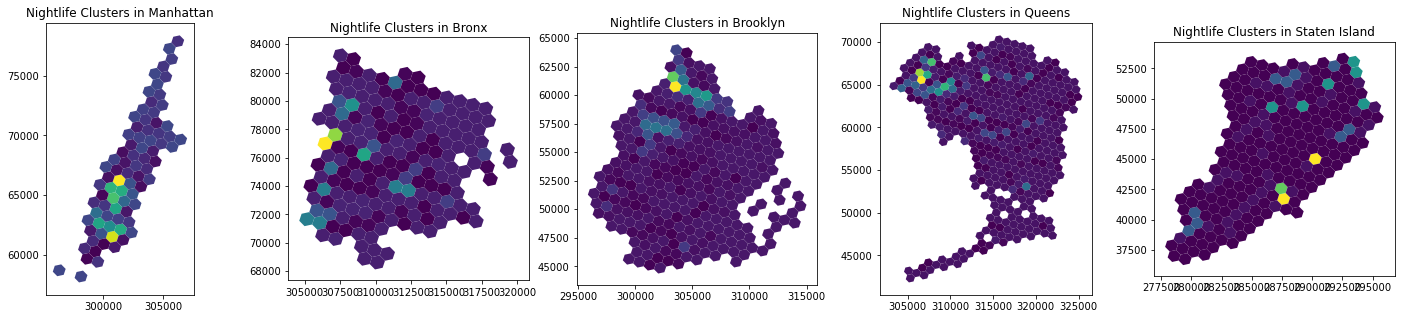

In [83]:
fig, ax = plt.subplots(1,5, figsize = (25,5))

for i in range(1,6):
    # access specific axis and filter data by boro
    sel_ax = ax[i-1]
    boro_venues = venues[venues['boro_code'].astype(int) == int(i)]
    
    # calculate z score
    boro_venues['count_z'] = np.abs(stats.zscore(boro_venues['venue_count']))

    # set up plot
    boro_name = list(set(boro_venues['boro_name']))[0]
    boro_venues.plot(ax    =sel_ax,
                     column='count_z'
                    )
    sel_ax.title.set_text(f"Nightlife Clusters in {boro_name}")

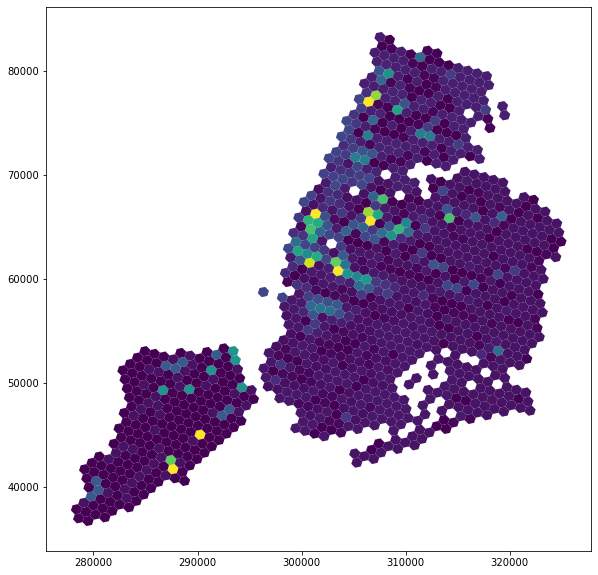

In [84]:
fig, ax = plt.subplots(1,1, figsize = (10,10))

for i in range(1,6):
    # filter data by boro
    boro_venues = venues[venues['boro_code'].astype(int) == int(i)]
    
    # calculate z score
    boro_venues['z'] = np.abs(stats.zscore(boro_venues['venue_count']))

    # set up plot and add boro data
    boro_name = list(set(boro_venues['boro_name']))[0]
    boro_venues.plot(ax=ax,
                     column='z')
    sel_ax.title.set_text(f"Boro-based Nightlife Clusters")

In [88]:
venues.to_file("../data/shapefiles/venues/venue_zscores.geojson",
               driver='GeoJSON')